# Restricted Boltzmann Machine using quantum annealing on D-wave's QPU

## Imports

In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from qrbm.MSQRBM import MSQRBM
from qrbm.classicalRBM import classicalRBM
from qrbm.ClassifierQRBM import ClassQRBM


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

import cv2 as cv

import random

## Presets

Here you can set hyperparameters for learning:

 - digits: list of digits to train on
 - THRESHOLD: how bright parts of image become 1 (darker become 0)
 - n_hidden: number of neurons in hidden layer
 - qpu: whether to use real D-wave's qpu (requires [setup](https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html)) or a local simulator
 - epochs: number of epochs
 - lr: learning rate


In [2]:
image_height = 28
image_width = 28

# images will be flattened
len_x = image_height * image_width
len_y = 0

digits = [0, 1]
# digits = list(range(5))
THRESHOLD = 100
n_hidden = 30
qpu = False
epochs = 1000
lr = 0.1

## reading dataset

In [3]:
mnist_dataset = pd.read_csv('./data/mnist_train.csv')
mnist_test = pd.read_csv('./data/mnist_test.csv')

## prepare train and test set

In [4]:
mnist_dataset[:10]

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
mnist_dataset[:10].values[:,0]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [6]:
X_train = mnist_dataset.values[:,1:]
X_train2 = mnist_dataset.values[:,:]
labels_train = mnist_dataset['label'].values

X_test = mnist_test.values[:,1:]
X_test2 = mnist_test.values[:,:]
labels_test = mnist_test['label'].values

# print(mnist_dataset.values[:,0])
X_train3 = []
X_test3 = []
labels_train3 = []
labels_test3 = []

for digit in digits:
    X_train3.append(mnist_dataset.values[np.where(mnist_dataset.values[:,0] == digit), 1:][0])
    labels_train3.extend(mnist_dataset.values[np.where(mnist_dataset.values[:,0] == digit), 0][0].tolist())
    X_test3.append(mnist_test.values[np.where(mnist_test.values[:,0] == digit), 1:][0])
    labels_test3.extend(mnist_test.values[np.where(mnist_test.values[:,0] == digit), 0][0].tolist())
# X_train3 = mnist_dataset.values[np.where(mnist_dataset.values[:,0] == 0), 1:]


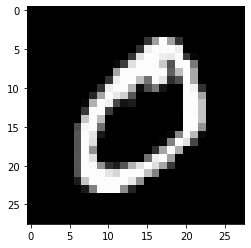

In [7]:
imgs = []
imgs_test = []
for digit_index in range(len(digits)):
    imgs.append(np.resize(X_train3[digit_index], (len(X_train3[digit_index]), 28, 28)) / 255)
    imgs_test.append(np.resize(X_test3[digit_index], (len(X_test3[digit_index]), 28, 28)) / 255)

plt.imshow(imgs[0][0])
plt.show()

## resizing images

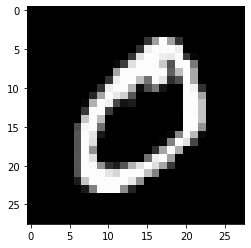

In [8]:
images_resized = []
images_resized_test = []
for digit_index in range(len(digits)):
    images_resized.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs[digit_index]])
    images_resized_test.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs_test[digit_index]])

    # images_resized = [resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs]

plt.imshow(images_resized[0][0])
plt.show()


## normalizing images

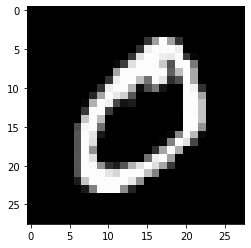

In [9]:
images_normalized = []
images_normalized_test = []

for digit_index in range(len(digits)):
    images_normalized.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized[digit_index]])
    images_normalized_test.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized_test[digit_index]])

    # images_normalized = [cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized]

plt.imshow(images_normalized[0][0])
plt.show()

## converting to binary

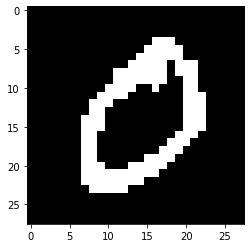

In [10]:
data = []
data_test = []
for digit_index in range(len(digits)):
    data.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized[digit_index]])
    data_test.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized_test[digit_index]])

# data = [np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized]

plt.imshow(data[0][0])
plt.show()


## flattening the image

In [11]:
input_data = []
input_data_test = []
for digit_index in range(len(digits)):
    input_data.append([x.ravel().tolist() for x in data[digit_index]])
    input_data_test.append([x.ravel().tolist() for x in data_test[digit_index]])

print(input_data[0][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 

In [12]:
len(input_data[1])

6742

In [13]:
result_picture_tab = []
for digit_index in range(len(digits)):
    result_picture_tab.append(np.mean(input_data_test[digit_index], axis = 0))

## shuffling the training data

In [14]:
for digit in digits:
    flat_input_data = np.array([item for sublist in input_data for item in sublist])
    flat_input_data_test = np.array([item for sublist in input_data_test for item in sublist])

# random.shuffle(flat_input_data)
# random.shuffle(flat_input_data_test)

## training

In [15]:
bm = ClassQRBM(flat_input_data[0], digits, n_hidden=n_hidden, qpu=qpu)

In [ ]:
bm.train(flat_input_data, labels_train3, epochs = epochs, lr = lr, lr_decay = 0.1)

## Trying classification

In [ ]:
for _ in range(5):
    random_id = np.random.randint(0, len(flat_input_data_test))
    test_img = np.reshape(flat_input_data_test[random_id], (image_width, image_height))
    plt.figure()
    plt.axis('off')
    plt.title("Image from test set", y=1.03)
    plt.imshow(test_img)
    plt.show()
    print('label:', labels_test3[random_id])
    result = bm.classify(flat_input_data_test[random_id])
    print(result)

## Trying generation

In [ ]:
for d in digits:
    print(d)
    result = bm.generate(d)
    result_img = np.reshape(result, (image_width, image_height))
    plt.figure()
    plt.axis('off')
    plt.title("Image from test set", y=1.03)
    plt.imshow(result_img)
    plt.show()